In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import cupy as cp
from cupy.sparse import cupyx as cpx
import cudf
import rapids_scanpy_funcs as rap
import pandas as pd
import numpy as np
import seaborn as sns
import anndata

import glob
samples=list(map(lambda p: "_".join(p.split("_")[:2]),glob.glob("*mtx*") ))

In [2]:
samples=glob.glob("**/**/**/filtered*/")

In [3]:
def load_filter_gpu(sample):
    print(sample)
    mtx_data=cudf.read_csv(sample+"matrix.mtx.gz",sep=" ",dtype=['float32' for i in range(3)],comment="%",header=None)

    data=mtx_data.iloc[1:,2].values
    row=mtx_data.iloc[1:,1].values
    col=mtx_data.iloc[1:,0].values
    
    barcodes=cudf.read_csv(sample+"barcodes.tsv.gz",header=None)["0"]
    
    genes=cudf.read_csv(sample+"features.tsv.gz",header=None,sep="\t")["1"]

    sp=cpx.scipy.sparse.coo_matrix((data, (row, col)),shape=(len(barcodes)+1,len(genes)+1))
    sp=sp.tocsr()[1:,1:]
    
    if sp.shape[0]>len(barcodes):
        sp=sp[:len(barcodes),:]
    

    min_genes_per_cell=200 
    max_genes_per_cell=10000

    sp,barcodes=rap.filter_cells(sp,
                     min_genes=min_genes_per_cell,
                     max_genes=max_genes_per_cell,
                       barcodes=barcodes)
    import numpy as np
    thr = np.asarray(sp.sum(axis=1) >= 400).ravel()

    sp=cp.sparse.csr_matrix(sp[thr,:])
    barcodes=barcodes[thr]
    
    

    return (sp,barcodes,genes)

In [4]:
alldata=list(map(load_filter_gpu,samples))

T/T_CR/outs/filtered_feature_bc_matrix/
S75T/S75T_CR/outs/filtered_feature_bc_matrix/
T200/T200_CR/outs/filtered_feature_bc_matrix/
T10/T10_CR/outs/filtered_feature_bc_matrix/
T19/T19_CR/outs/filtered_feature_bc_matrix/
S162T/S162T_CR/outs/filtered_feature_bc_matrix/
T34/T34_CR/outs/filtered_feature_bc_matrix/
T40/T40_CR/outs/filtered_feature_bc_matrix/
T175/T175_CR/outs/filtered_feature_bc_matrix/
T69/T69_CR/outs/filtered_feature_bc_matrix/
T230/T230_CR/outs/filtered_feature_bc_matrix/
S71T/S71T_CR/outs/filtered_feature_bc_matrix/
S92IV/S92IV_CR/outs/filtered_feature_bc_matrix/
S214T/S214T_CR/outs/filtered_feature_bc_matrix/
T188/T188_CR/outs/filtered_feature_bc_matrix/
T27/T27_CR/outs/filtered_feature_bc_matrix/


In [5]:
allsp=list(map(lambda tp: tp[0],alldata))
sp=cpx.scipy.sparse.vstack(allsp)

In [6]:
allbarcodes=list(map(lambda tp: tp[1],alldata))
newbc=list(map(lambda i: list(map(lambda bc: bc.split("-")[0]+"-"+str(i+1),allbarcodes[i].to_pandas())),range(len(allbarcodes))))
allbc=np.concatenate(newbc)

In [7]:
genes=alldata[0][2].to_array()

<AxesSubplot:>

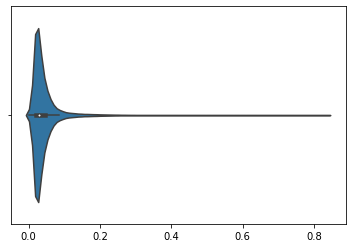

In [8]:
mito_genes=np.char.startswith(genes.astype(str),"MT-")
n_counts = sp.sum(axis=1).ravel()
mito_counts=sp[:,mito_genes].sum(axis=1).ravel()
mito_prop=mito_counts/n_counts
sns.violinplot(mito_prop.get(),orient="v")

In [9]:
sp=sp[mito_prop<0.10,:]

In [10]:
adata = anndata.AnnData(sp.get())
adata.var_names = genes
adata.obs_names = allbc[mito_prop.get()<0.10]
adata.obs["mito_prop"]=mito_prop[mito_prop<0.10].get()
adata.obs["n_counts"]=sp.sum(axis=1).get()

In [11]:
adata.var_names_make_unique()
sc.pp.filter_genes(adata,min_cells=1)
adata.write_h5ad("adata_raw.h5ad")

In [12]:
adata.obs["sample"]=list(map(lambda bc: int(bc.split("-")[1]),adata.obs_names))

In [14]:
ids=list(map(lambda s: s.split("/")[0],samples))
adata.obs["sample"]=adata.obs["sample"].astype("category")

In [15]:
adata.obs["sample"]=adata.obs["sample"].cat.rename_categories(ids)

In [16]:
sc.pp.filter_genes(adata,min_cells=3)

In [17]:
sc.pp.normalize_total(adata,target_sum=1e6)

In [18]:
sc.pp.log1p(adata,base=10)

In [19]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger")

In [20]:
scaled = cp.array(adata[:,adata.var["highly_variable"]].X.todense(), order="F")
scaled = rap.scale(scaled, max_value=10)

In [21]:
from cuml import PCA
adata.obsm["X_pca"] = (PCA(n_components=50).fit_transform(scaled)).get()

In [24]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30,method="rapids")

In [25]:
sc.tl.umap(adata,method="rapids")

In [26]:
from scanpy._utils import _choose_graph
adjacency = _choose_graph(adata,None,None)
import cudf
import cugraph
offsets = cudf.Series(adjacency.indptr)
indices = cudf.Series(adjacency.indices)
weights = None
g = cugraph.Graph()
g.add_adj_list(offsets, indices, weights)
leiden_parts, _ = cugraph.leiden(g,resolution=.5)
groups = leiden_parts.to_pandas().sort_values('vertex')[['partition']].to_numpy().ravel()
adata.obs["leiden"]=groups.astype(str)
adata.obs.leiden=adata.obs.leiden.astype("category")

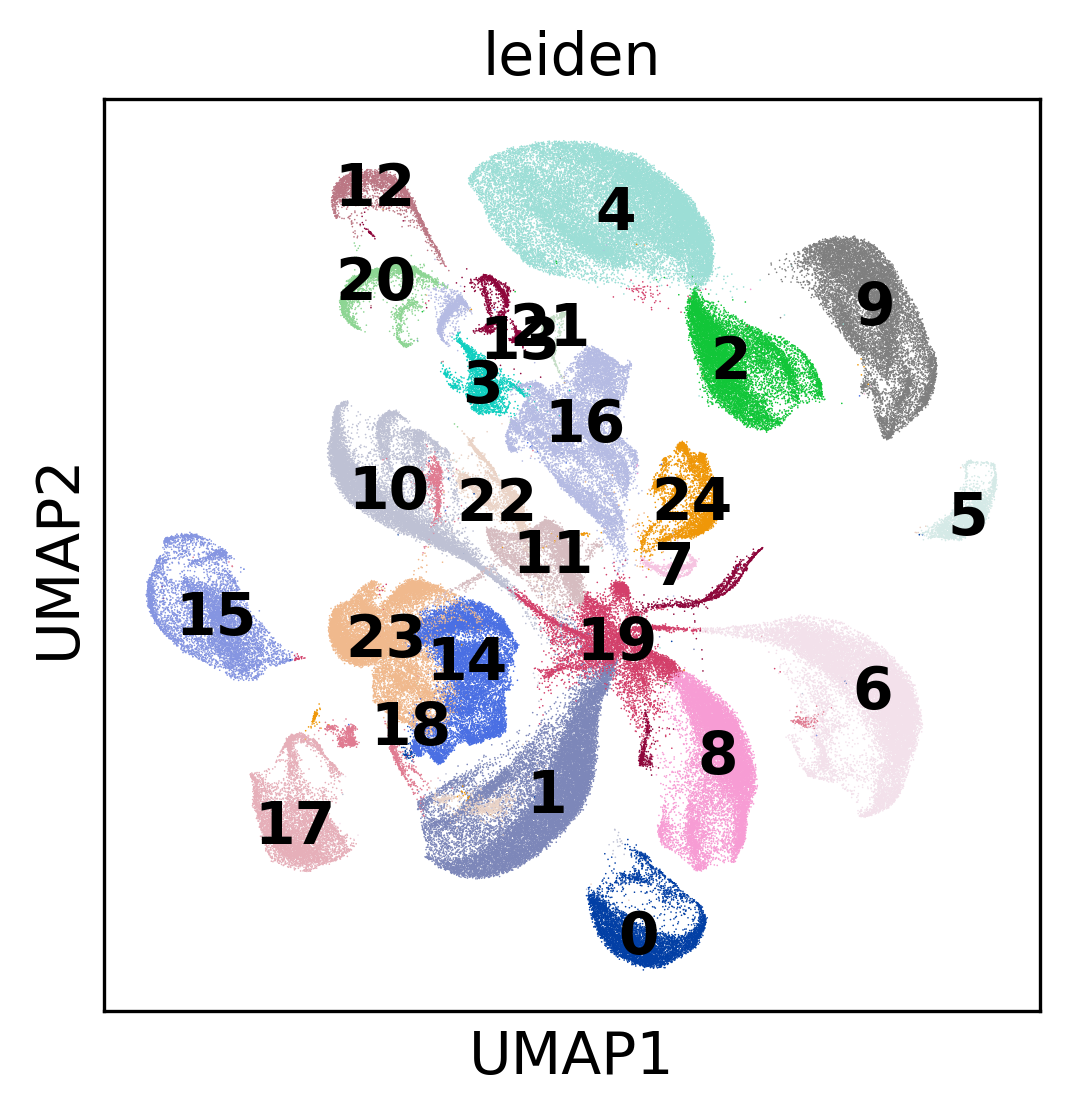

In [27]:
sc.settings.set_figure_params(dpi=150, facecolor='white')
sc.pl.umap(adata,color="leiden",legend_loc="on data")

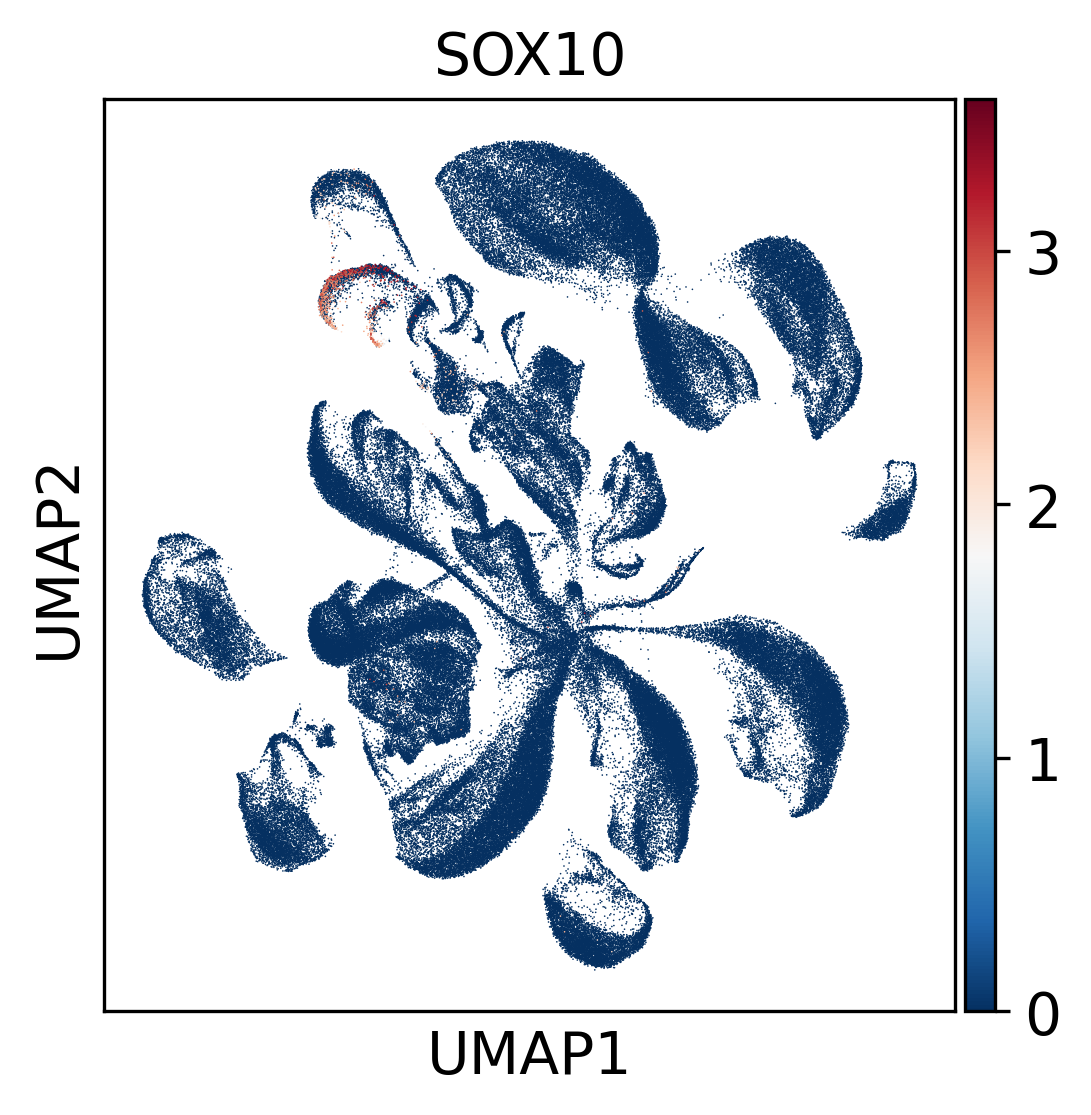

In [28]:
sc.pl.umap(adata,color="SOX10",color_map="RdBu_r")

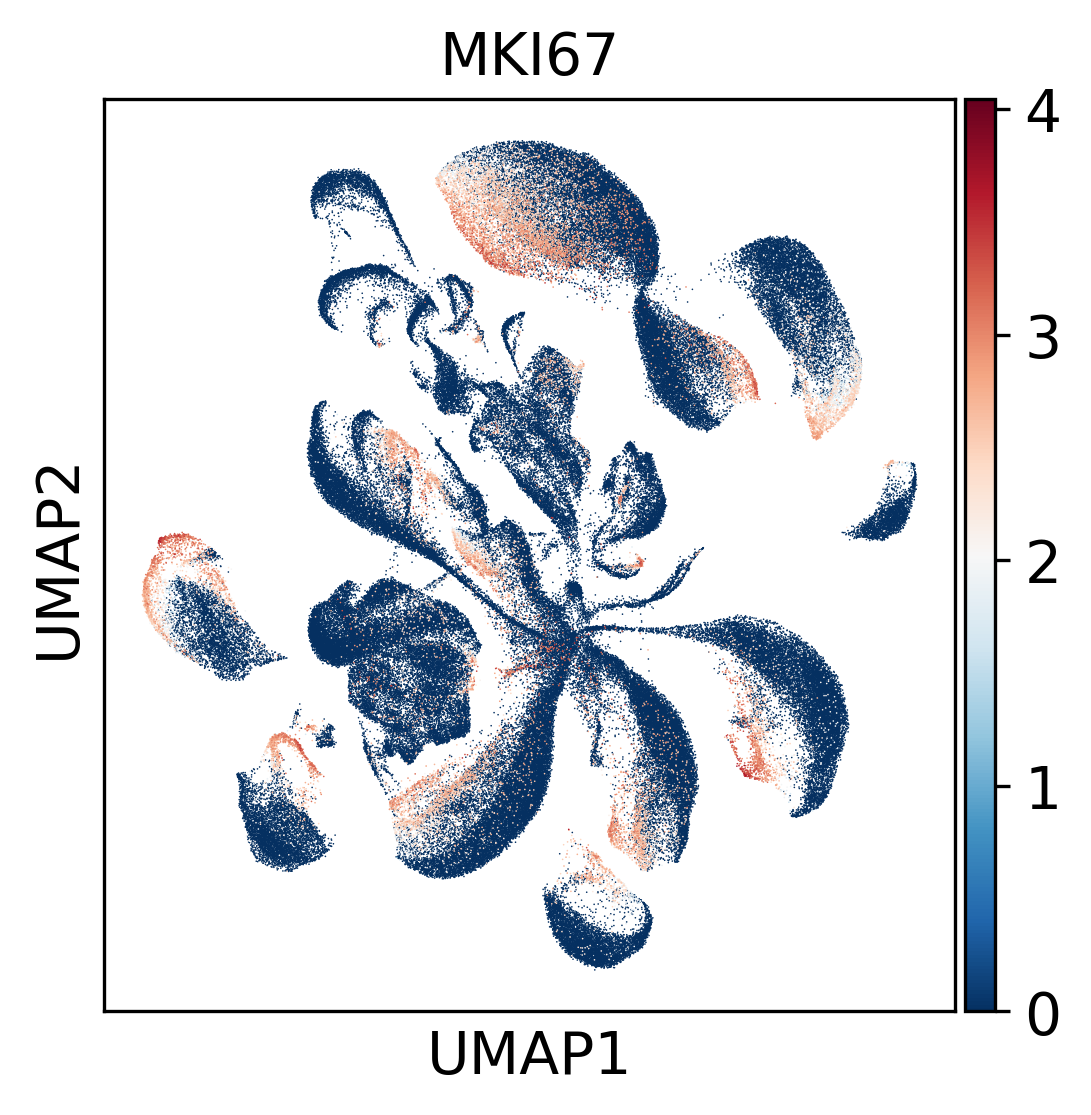

In [29]:
sc.pl.umap(adata,color="MKI67",color_map="RdBu_r")

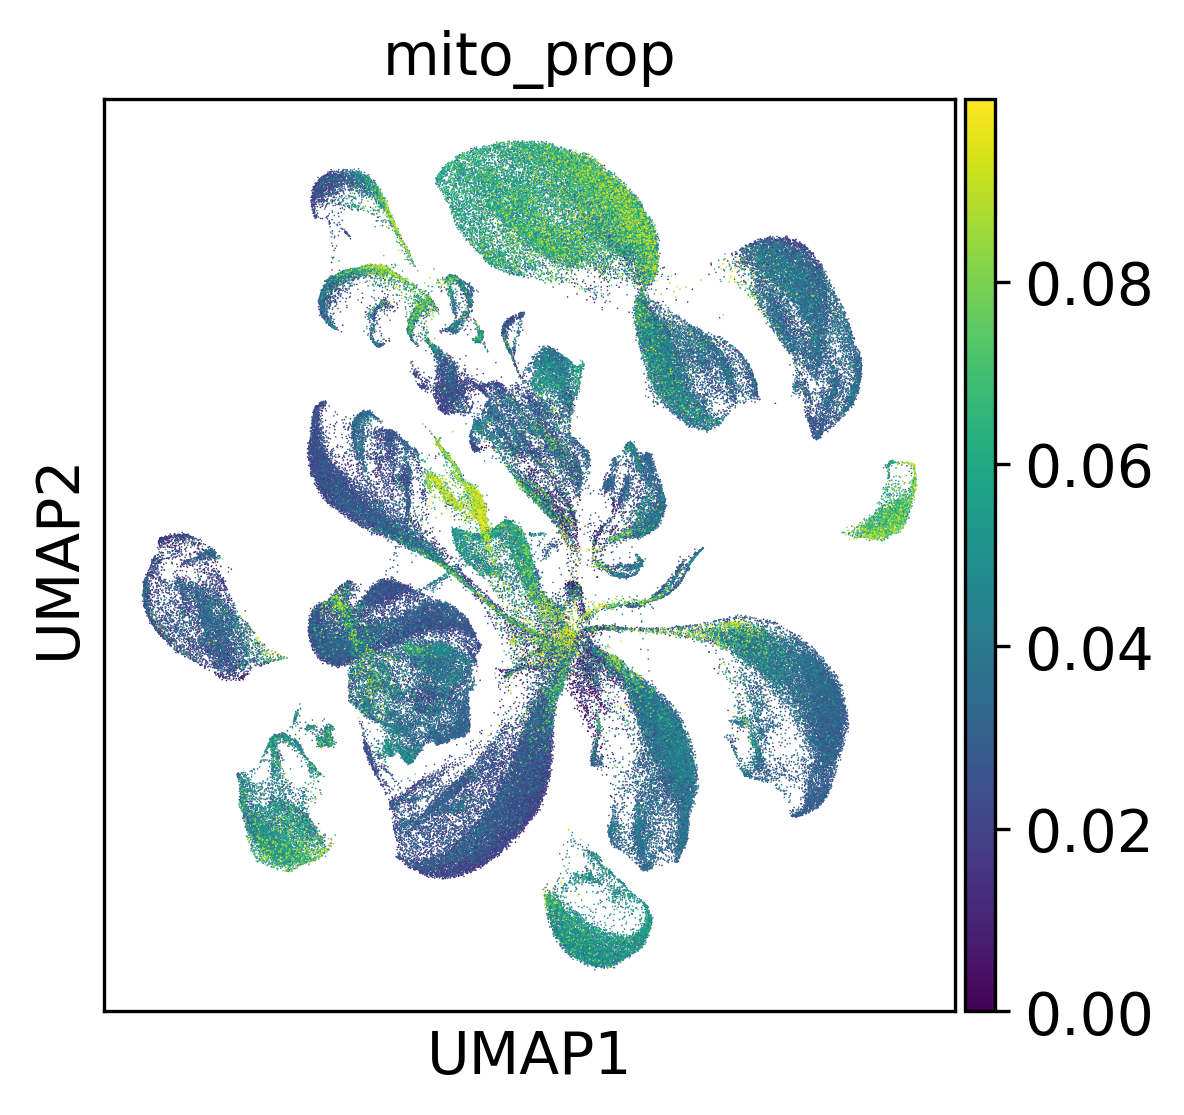

In [30]:
sc.pl.umap(adata,color="mito_prop",color_map="viridis")

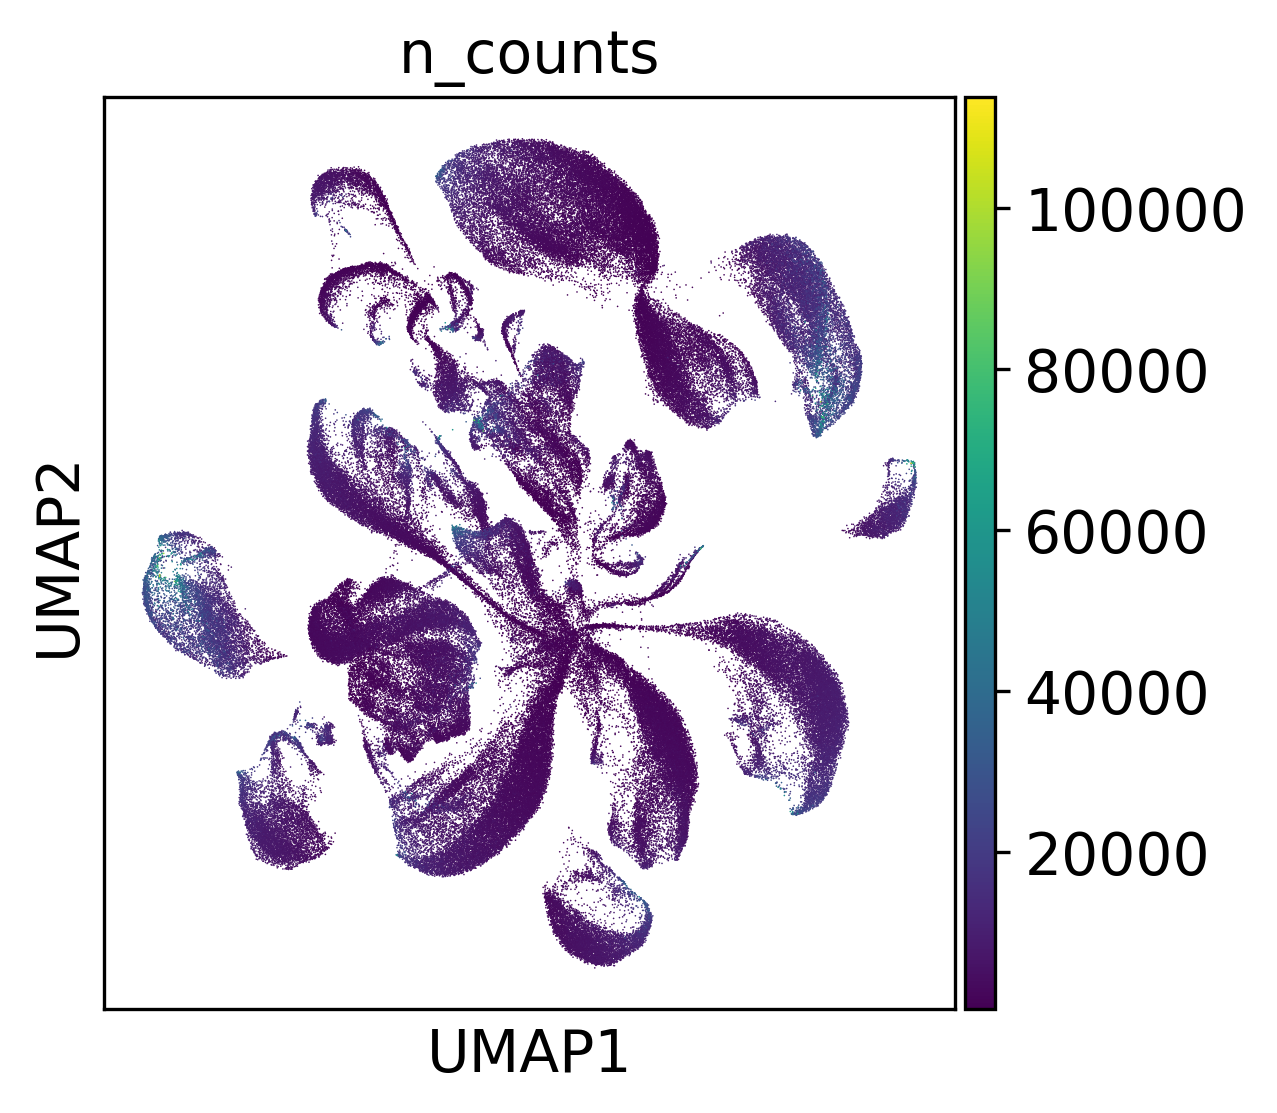

In [31]:
sc.pl.umap(adata,color="n_counts",color_map="viridis")

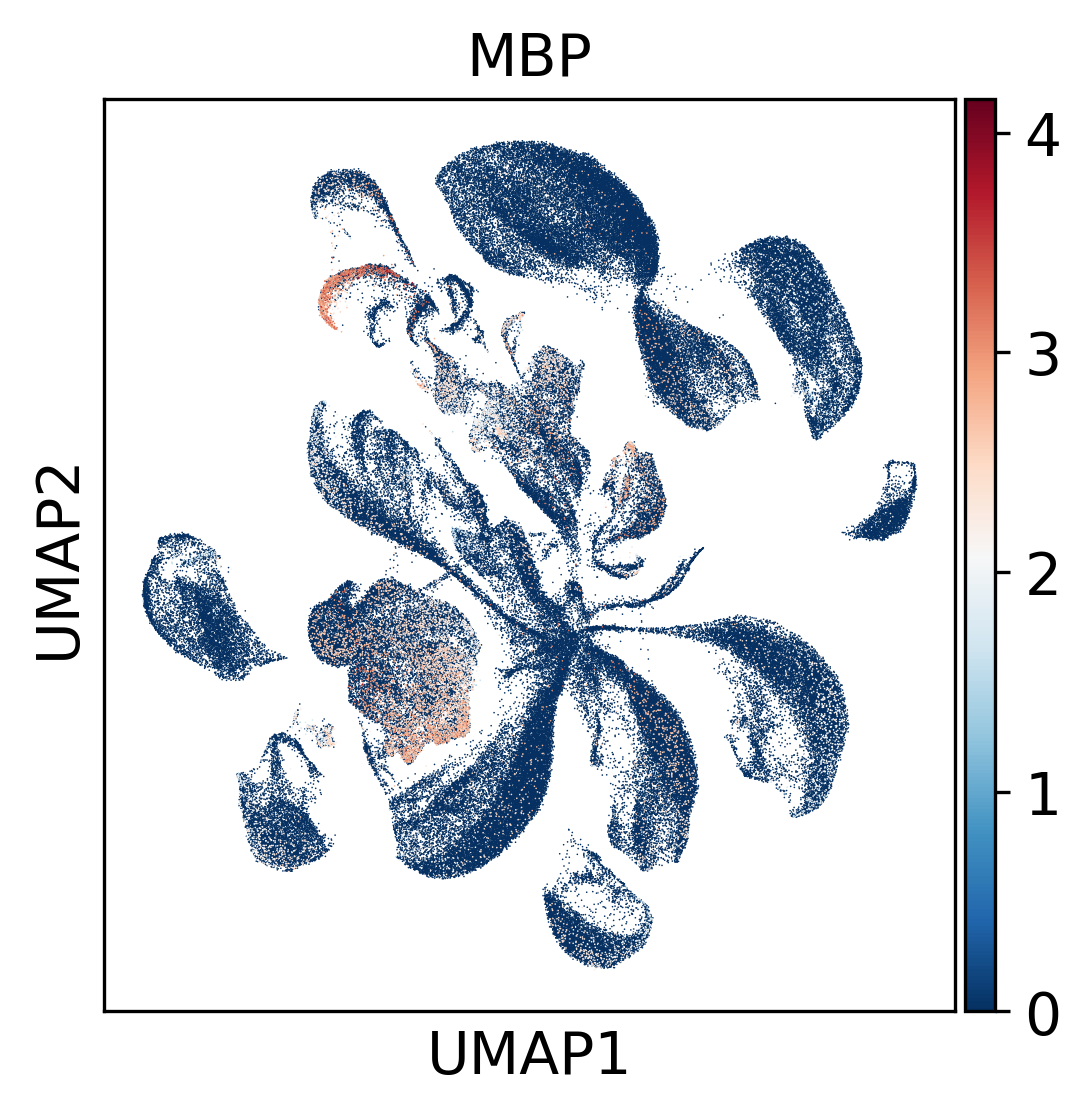

In [32]:
sc.pl.umap(adata,color="MBP",color_map="RdBu_r")

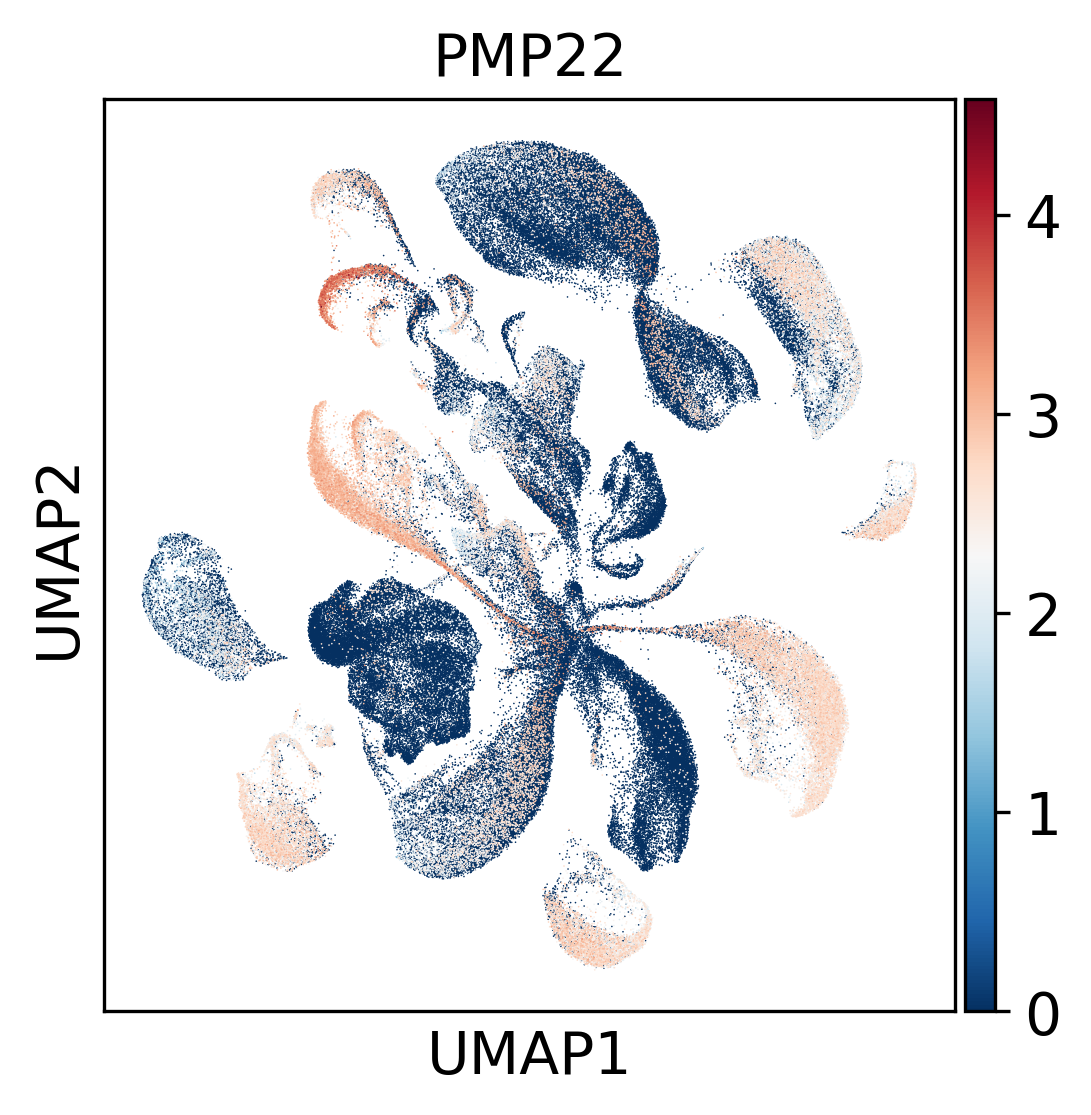

In [33]:
sc.pl.umap(adata,color="PMP22",color_map="RdBu_r")

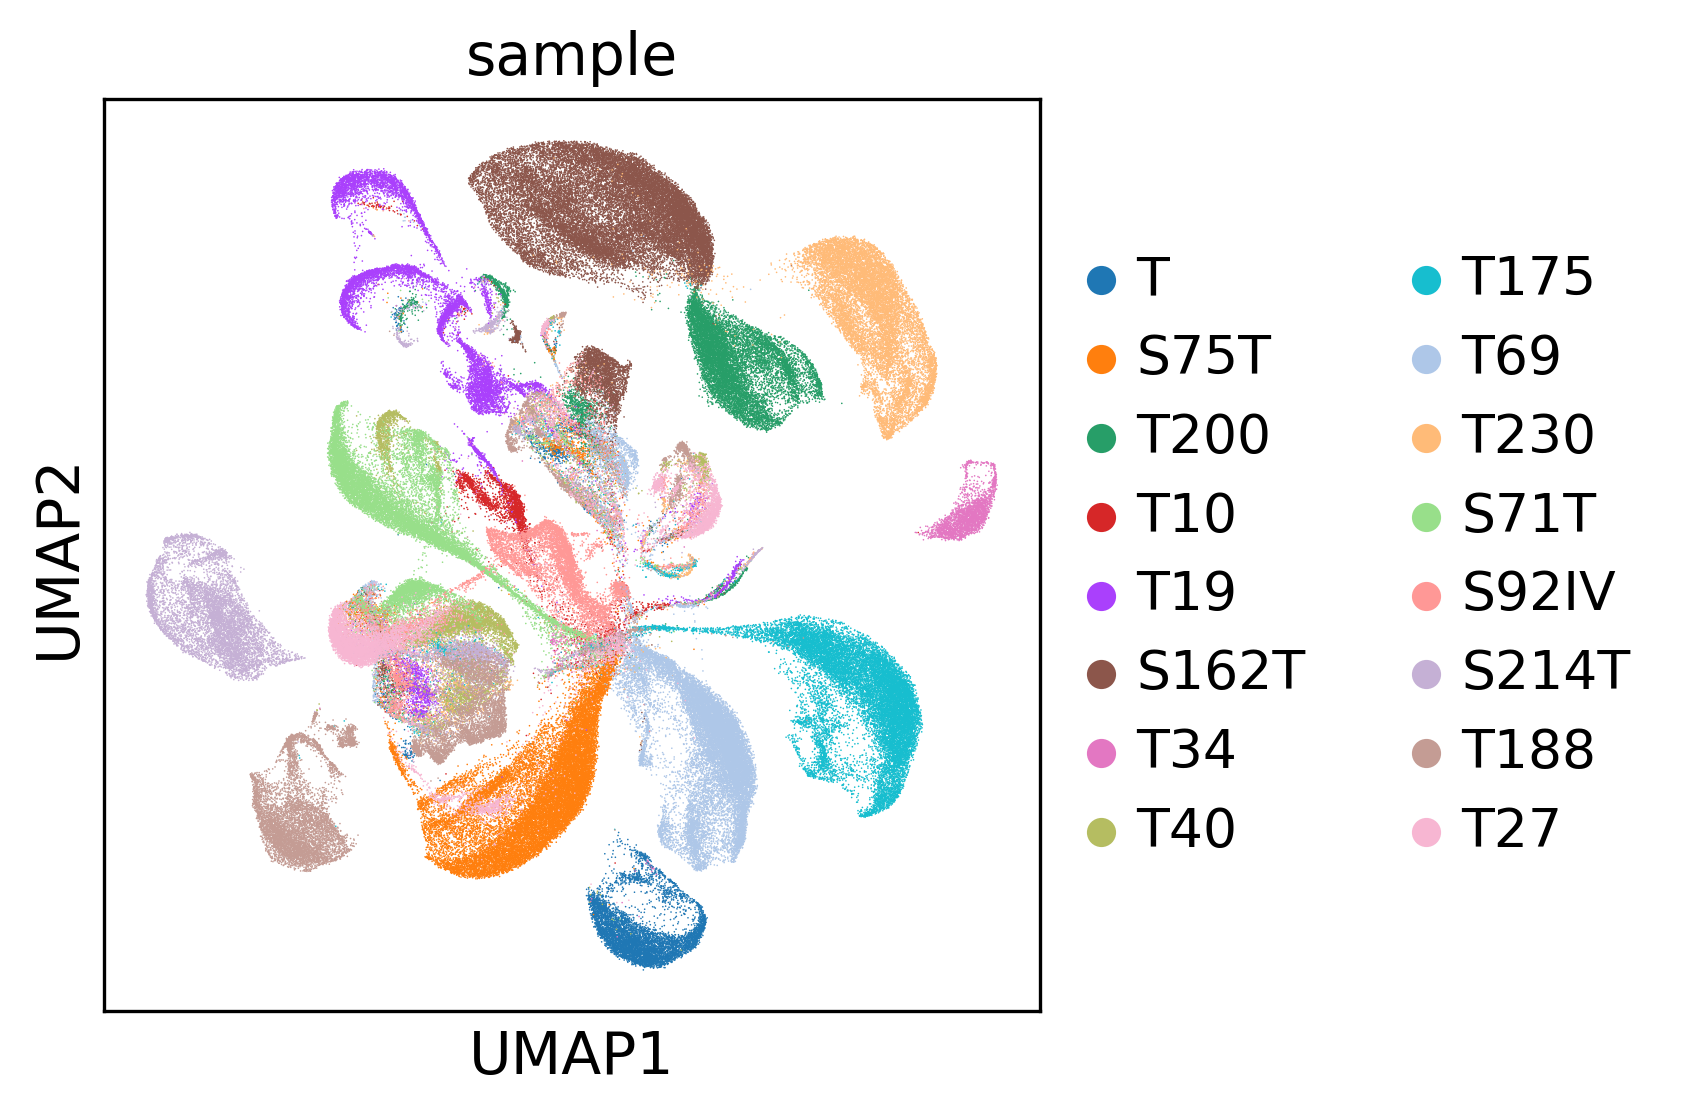

In [34]:
sc.pl.umap(adata,color="sample")

In [35]:
adata.write_h5ad("adata_all.h5ad")